# English Intensifers in Learner Text

LING 530B <br>
Khia Johnson <br>
April 15, 2019

---

## Import and reshape data

In [ ]:
import json
import time
import re
import numpy as np
import pandas as pd

The following functions are used to reshape and modify the dataframe:

In [ ]:
def expand(df_initial, col_to_expand, drop_list):
    temp = df_initial[col_to_expand].apply(pd.Series)
    to_stack = pd.concat([df_initial, temp], axis = 1).drop(columns = drop_list, axis=1)
    return to_stack
    
def stack(df_expanded, index_list, new_name):
    df_expanded.set_index(index_list, inplace=True)
    stacked = pd.DataFrame(df_expanded.stack(dropna=True))
    stacked.reset_index(inplace=True)
    stacked.rename(columns={0:new_name}, inplace=True)
    return stacked

def prop_l1_en(row):
    friends = dict(row['Friends'])
    count = 0
    for f in friends:
        if friends[f]['L1'] == 'English':
            count+=1
    return(count/len(friends))

def count_friends(row):
    return len(dict(row['Friends']))

def pull_journals(row):
    entries = []
    cell = dict(row['Journal'])
    for i in cell:
        entries.append((cell[i]['entry_date'],cell[i]['entry_text'],cell[i]['comments'],i))
    return entries

def clean_date(row):
    if (type(row['Text'])==list):
        return row['Text'][0]
    else:
        return row['Date'].split('\n')[0]

def extract_year(row):
    year = row['Date'].split()[2]
    return int(year)
    
def clean_text(row):
    if (type(row['Text'])==list):
        return row['Text'][1]
    else:
        return row['Text']

In [ ]:
data = {}
with open('530_project_data.txt') as file:
    for row in file:
        data.update(json.loads(row.strip()))

df = pd.DataFrame.from_dict(data, orient='index')
df.reset_index(inplace=True)

In [ ]:
# Expand profile information and rename columns
df = expand(df, 'profile', ['profile','Nation_and_region','Twitter_ID','Real_name','Skype_ID',
                            'Birthday','Facebook_ID','ID','Occupation','L_points'])

df.rename(columns={'index': 'User',
                   'friends': 'Friends',
                   'journal': 'Journal',
                   'Entries_written': 'N_entries',
                   'Corrections_made': 'Corr_made',
                   'Corrections_rcvd': 'Corr_rcvd'
                  }, inplace=True)

In [ ]:
# Add columns
df['L1E_frnds'] = df.apply(prop_l1_en, axis=1)
df['N_friends'] = df.apply(count_friends, axis=1)
df['Entry'] = df.apply(pull_journals,axis=1)

In [ ]:
# reshape
df_e = expand(df, 'Entry', ['Journal','Entry','L2','Friends'])
df_s = stack(df_e, list(df_e)[0:10], 'Stacked').drop(columns=['level_10'])
df = expand(df_s, 'Stacked', ['Stacked']).rename(columns={0:'Date',1:'Text',3:'Url'}).drop(columns=[2])

In [ ]:
# Clean up text and data types
df['Date'] = df.apply(clean_date,axis=1)
df['Text'] = df.apply(clean_text,axis=1)
df['Year'] = df.apply(extract_year,axis=1)
df['Age'] = df['Age'].astype(int)
df['N_entries'] = df['N_entries'].str.replace('[^0-9]', '', regex = True).astype(int)
df['Corr_made'] = df['Corr_made'].str.replace('[^0-9]', '', regex = True).astype(int)
df['Corr_rcvd'] = df['Corr_rcvd'].str.replace('[^0-9]', '', regex = True).astype(int)
df.dtypes

In [ ]:
# Filter by user level information
df = df.loc[~df['Sex'].isna()]
df = df.loc[df['Age'] < 100]
df = df.loc[df['Age'] > 17]
df = df.loc[df['N_entries'] > 4]
df = df.loc[df['L1'] != 'English']
df.reset_index(drop=True, inplace=True)

# len(df) # out = 58121

## Tag text and extract adjectives

In [ ]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer(reduce_len=True, preserve_case=False)

from nltk.tag.stanford import StanfordPOSTagger # StanfordPOSTagger with GATE twitter model
st = StanfordPOSTagger(model_filename='gate-EN-twitter-fast.model',
                       path_to_jar='stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2.jar')

from spellchecker import SpellChecker
spell = SpellChecker()

In [ ]:
# clean up the text and tokenize
df['Text'] = df['Text'].str.replace('`', "'")
df['Text'] = df['Text'].str.replace(r"""[^0-9A-Za-z\s.,!?:;/\"'_\-\=+\#$%\^&*{}~()]""","",regex=True)
tokenized = df['Text'].astype(str).apply(tt.tokenize)

In [ ]:
# POS tag in batches
tagged = [] # comment this line if need to restart part way through
i = len(tagged)

while i < len(df):
    start = time.time()
    batch = st.tag_sents(tokenized[i:i+1000])    
    tagged.extend(batch)
    i = len(tagged)

In [ ]:
df['Tokenized'] = tokenized
df['Tagged'] = tagged

In [ ]:
# Code for saving and restarting from CSV later
#df.to_csv('full_df_tagged.csv', encoding='utf-8')
#df = pd.from_csv('full_df_tagged.csv', encoding='utf-8')

In [ ]:
# Function to find adjectives in POS-tagged text. Also gets context and adverb ('RB'() if preceded by one.
# Note: 'JJ' does not include comparative/superlative.
def find_JJ_and_context(row):  
    jjs = [index for index, word in enumerate(row['Tagged']) if word[1]=='JJ']
    jj_context = []
    
    for i in jjs:
        start = i - 4
        end = i + 5
        if start < 0:
            start = 0
        if end > len(row['Tagged']):
            end = len(row['Tagged'])
        adverb = ''
        if i > 0 and row['Tagged'][i-1][1]=='RB':
            adverb = row['Tagged'][i-1][0]
        jj_context.append((adverb, row['Tagged'][i][0], row['Tagged'][start:end]))     
        
    return jj_context

In [ ]:
# Find adjectives (and context, adverbs) and reshape
df['Adj_list'] = df.apply(find_JJ_and_context, axis=1)
stacked = stack(expand(df, 'Adj_list', ['Tokenized','Tagged','Adj_list']), list(df)[0:14], 'Stacked')
fulldf = expand(stacked, 'Stacked', ['Stacked'])
fulldf.rename(columns={'level_14':'N_in_text', 0:'Adverb', 1:'Adjective' ,2:'Context'}, inplace=True)

In [ ]:
# Clean up adjectives and filter out clear erroras
fulldf['Adjective'] = fulldf['Adjective'].str.lower()
filtered = fulldf.loc[~fulldf['Adjective'].str.contains("[^a-z\-'\.]",regex=True)]
filtered = filtered.loc[(filtered['Adjective'].str.len() < 25) & 
                        (filtered['Adjective'].str.len() > 3) | 
                        (filtered['Adjective']=='ok')]

## Clean up adverbs and identify intensifiers

In [ ]:
print(set(filtered['Adverb']))

**OUT:** {'', 'fiendishly', 'richly', 'constitutionally', 'downward', 'directly', 'yoshinoya', 'errors-especially', 'absolutelly', 'quitly', 'apart', 'secretly', 'sincerely', 'severely', 'nationally', 'northwest', 'locally', 'realily', 'altogether', 'ordinally', 'jam.the', 'importantly', 'therefor', 'moderately', 'province.before', 'slightly', 'partly', 'toefl', 'perfectly', 'before.most', 'dimly', 'endlessly', 'stiill', 'negatively', 'thankfully', 'either', 'wrongly', 'uo', 'throughly', 'kindly', 'even', 'cearly', 'somewhere', 'blissfully', 'surly', 'rediculously', 'olerly', 'still', 'strictly', 'heartily', 'intensely', 'also', 'ultimately', 'ahead', 'professionally', 'slighutly', 'her.judy', 'anytime', 'bendingly', 'fully', 'substantially', 'ridiculously', 'perhaps', 'fucking', 'else', 'loudly', 'absurd-ridiculously', 'maybe', 'occasionally', 'profoundly', 'firstly', 'english.secondly', 'considerablely', 'intensively', 'ecology.how', 'overwhelmingly', 'very', 'down', 'potentially', 'highly', 'amazingly', 'apparently', 'further', 'theoretically', 'absolutely', 'finely', 'lawfully', 'suprisingly', 'now.the', 'relly', 'often', 'massively', 'automatically', 'annoyingly', 'abroad', 'nt', 'verly', 'verry', 'that', 'startlingly', 'alone', 'exeptionally', 'anyway', 'anytimes.as', 'so', 'unexpectedly', 'randomly', 'normally', 'inevitably', 'indeed', 'unwittingly', 'educationally', 'around', 'clealy', 'incredibly', 'selfishly', 'pleasantly', 'miserably', 'nevertheless', 'alike', 'now', 'awake', 'equally', 'deliriously', 'thatthe', 'finally', 'legendarily', 'unduly', 'zzzzzz', 'unnecessarily', 'over', 'trully', 'environmentally', 'evidently', 'remarkably', 'angrily', 'artist.especially', 'wildly', 'seemingly', 'higly', 'racially', 'fluentily', 'biologically', 'junnior', 'sexually', 'involuntarily', 'surper', 'inereasingly', 'wonderfully', 'simply', 'gladly', 'afterthe', 'necessarily', 'stupidly', 'positively', 'shopping.how', 'previously', 'anywhere.the', 'accordingly', 'linguistically', "i'll", 'horribly', 'extrmely', 'well', 'astoundingly', 'here.so', 'traditionally', 'drastically', 'considerbly', 'precisely', 'tortally', 'continuously', 'superlatively', 'little', 'rappidly', 'thoughtful.the', '2.simple', 'contextually', 'unforgettably', 'somewhat', 'olnly', 'tooo', 'overly', 'homestay', 'nowvery', 'unbelievablily', 'inherently', 'pretty', 'relatevely', 'thereby', 'quietly', 'eerily', 'enjoyable.the', 'coolly', 'mutually', 'deliberately', 'technically', 'alledgedly', 'entirely', 'faintly', 'quite', 'socially', 't', 'kinda', 'totallly', 'epidemically', 'stil', 'commercially', 'warmly', 'low.how', 'unnaturally', 'all', 'longer', 'tenfold', 'out', 'delightfully', 'nightly', 'ripely', 'orally', 'reaaly', 'neither', 'radiate', 'alredy', 'perpetually', 'irreducibly', 'suitably', 'desparately', 'unmistakably', 'tottally', 'actually', 'overtly', "we're", 'elsewhere', 'visualy', 'leisurely', 'probably', 'unusually', 'politely', 'readily', 'right', "i'm", 'south', 'definitely', 'simultaneously', 'wally', 'africn', 'competitively', 'historically', ':o)', 'extraordinarily', 'incomparably', 'roughly', 'dreadfully', 'literally', 'originally', 'grammarly', 'chibly', 'anymore', 'obediently', 'through', 'immensly', 'thoroughly', 'archer', 'actively', 'abnormally', 'however', 'fluently', 'before.but', 'suddenly', 'realy', 'now.how', "wasn't", 'iitaly', 'therefore', 'esp', 'freaking', 'rather', 'accurately', 'veru', 'no.two', 'sufficiently', 'appearlently', 'vasily', 'undoubtedly', "there're", 'languidly', 'uncommonly', 'seldom', 'expecially', 'superiorly', 'revand', 'unconditionally', 'essentially', 'fast', 'uncountably', 'incrediblely', 'acutely', 'far', 'kind', 'painfully', 'highest', 'effectively', 'preternaturally', 'vividly', 'successfully', 'recently', 'cleanly', 'forever', 'kindda', 'visually', 'relatively', 'seriously', 'herlady', 'extremely', 'culturally', 'ohysically', 'vitally', 'absluately', 'extreamly', 'solely', 'correspondently', 'numerically', 'limitlessly', 'statistically', 'genuinely', 'almost', 'immorally', 'increaseingly', 'hermionerubber', 'mildly', 'xiao', 'cetainly', 'nattou', 'plenty', 'differently', 'frequently', 'meanwhile', 'late', 'htc', 'unfortunally', 'sia', 'early', 'strategically', 'efficiently', 'utterly', 'temporarily', 'overtime', 'personally', 'infinitely', 'awfully', 'decently', 'basically', 'ang', 'ostensibly', 'nicely', 'unconsciously', 'as', 'afterward', 'tow', 'hard', 'naturally', 'internationally', 'consequently', 'since', 'emotionally', 'effortlessly', 'just', 'quickly', 'absolutly', 'crazily', 'because', 'fundamentally', 'no-distance.how', 'formally', 'definately', 'notoriously', 'alotof', 'beautifully', 'increasingly', 'closely', 'back', 'incedibly', 'explicitly', 'lately', 'psychologically', 'approximately', 'supecially', 'intactas', 'freshly', 'smoothly', 'bery', 'preciously', 'eternally', "you're", 'likewise', 'absoluetly', 'weekly', 'veri', 'soundly', 'exceptionally', 'downright', 'functionally', 'morally', 'adequately', 'half', 'unprecedentedly', 'especially', 'bit', 'tacitly', 'booksespecially', 'too.how', 'minimally', 'ago.now', 'hella', 'soo', 'sososososo', 'dialy', 'silently', 'legally', 'oddly', 'after', 'mainly', 'annually', 'busily', 'forward', 'ever', 'extrimely', 'junir', 'barely', 'ill', 'blatant-unpleasantly', 'finacially', 'eventurally', 'north', 'no', 'therere', 'analytically', 'hugely', 'asleep.the', 'vely', 'anew', 'usually', 'surely', 'toatly', 'asia', 'really', 'espesially', 'supposedly', 'unquestionably', 'desperately', 'counter', 'vertically', 'fatally', 'astonishingly', 'ely', 'seemly', 'students-especially', 'tipically', 'tediously', 'aloso', 'twice', 'properly', 'namely', 'ofently', 'unrealistically', 'bitterly', 'together', 'thematically', 'exremely', 'secondly', 'sharply', 'proportionally', 'excellently', 'here', 'enough', 'offcially', 'financially', 'always', "i'v", 'harmfully', 'priodically', 'zzz', 'sooo', 'allah', 'painstakingly', 'clinically', 'close', 'senselessly', 'damn', 'm1tsuewooly', 'super', 'them.how', "nothing's", 'tremendously', 'soon.so', 'ethically', 'rily', 'creepily', 'long', "that's", 'truly', 'ago', 'first', 'nearby', 'sorta', 'there.at', 'conceptually', 'easily', 'crealy', 'soon', 'badly', "n't", 'nowadays', 'unfortunately', 'kown', 'supremely', 'soon.the', 'aside', 'catalytically', 'similarly', 'strongly', 'extreamely', 'how', 'likeeise', 'already.the', 'mind-numbingly', 'moneyusually', 'brightly', 'terriblely', 'reciprocally', 'aproximatelly', 'short', 'undeniably', 'aboard', 'immense-extremely', 'gradually', 'strikingly', 'overseas', 'everytime', 'eternally.and', 'round', 'before', 'pleasingly', 'alive', 'happily', 'already', 'wholly', 'slowly', 'sometimes', 'it.another', 'cross-nationally', 'fairly', 'virtually', 'economically', 'rightly', 'it.especially', 'jilly', 'nosso', 'toatolly', 'respectively', 'hardly', 'thus', 'reaklly', 'comparatively', 'once', 'there.the', 'entirlely', 'absolotely', 'oast', 'alarmingthe', 'civically', 'ordinaly', 'plusconstantly', 'honestly', 'betterso', 'abnomally', 'sligtly', 'distinctly', 'breathtakingly', 'mayby', 'largely', 'thesedays', 'typically', 'deeply', 'reeeally', 'poorly', 'everywhere', 'freezingly', 'inversly', 'grimly', 'strategicall', 'clearly', 'up', 'nowhere', 'unreasonably', 'outrageously', 'aloud', 'globally', 'japanespecially', 'allways', 'especiallly', 'technicaly', 'intrinsically', 'horrifyingly', 'humanly', 'coldly', 'finaly', 'a1.in', 'truely', 'along', 'abroad.at', 'relativly', 'adversely', 'fortunately', 'unbelievably', 'doubtless', 'therr', 'incidentally', 'juniour', 'frightfully', 'anh', 'uniquely', 'disappointingly', 'instill', 'hightly', 'handsomely', 'narrowly', 'soond', 'tottaly', 'rainly', 'genetically', 'deliciously', 'completly', 'londly', 'enormously', 'hotly', 'there', 'completely', 'predominantly', 'months.really', 'too', 'solo', 'universally', 'admittedly', 'violently', 'exams.therefore', 'expressly', 'alwyas', 'tonight', 'peacefully', 'quitely', 'luckily', 'reasonably', 'thn', 'bacause', 'inversely', 'alway', 'exceedingly', 'terribly', 'somehow', 'fiercely', 'thinly', 'toughly', 'commentedpsychologically', 'sososo', 'way', 'instagram.the', 'furthermore', 'abouit', 'torino', 'breath-takingly', 'influent', 'instead', 'undoubtly', 'initially', 'regardless', 'sparsely', 'propably', 'geographically', 'widely', 'otherwise', 'politically', 'only', 'home', 'someday', 'physically', 'in', 'away', 'thousand-hand', 'terminally', 'reallyyy', 'particularly', 'commonly', 'extream', 'eventually', 'lightly', 'religiously', 'bascially', 'uncontrollably', 'acutally', 'reaaally', 'grammatically', 'reeaaally', 'partially', 'unceasingly', 'especialy', 'most', 'keenly', 'complelely', 'definetely', 'artificially', 'numerously', 'forth', 'spically', 'officially', 'insanely', 'insatiably', 'arguably', 'nearly', 'hopefully', 'alexander', 'adorably', 'mentally', 'you.very', "they'll", 'specifically', 'neirumun', 'easyly', 'this.and', 'later', 'though', 'invariably', 'asleep', 'extremly', 'juior', 'everyday', 'merely', 'never', 'altrought', 'chiefly', 'surprisingly', 'then', 'extensively', 'extramely', 'rapidly', 'better', 'incorrectly', 'turely', 'exactly', 'practically', 'sadely', 'bike', 'mostly', 'english.how', 'dangerously', 'subsequently', 'littl', 'dramatically', 'rearly', 'grossly', 'best', 'ther', 'much', 'abbey', 'specially', 'exclusively', 'about', 'more.too', 'verrry', 'consistently', 'scarcely', 'reversely', 'all-new', 'possibly', 'them.the', 'again', 'not', 'incoherently', 'carefully', 'logically', 'academically', 'excessively', 'newly', 'gramatically', 'respectfully', 'unspeakably', 'preey', 'campsespecially', 'obviously', 'sometime', 'hence', 'ompletely', 'totally', 'hervery', 'allthough', 'anywhere', 'significantly', 'purely', 'eminently', 'radically', 'rarely', 'nothinge', 'interesting.especially', 'densely', 'eapecially', 'befficiently', 'curiously', 'fantastically', 'unwillingly', 'incresingly', 'totaly', '):', 'obiously', 'foremost', 'moreover', 'broadly', 'paly', 'freely', 'compretrely', 'currently', 'considerably', 'everything.the', 'greatly', 'blindingly', 'homogeneously', 'funnily', 'hta', 'archaeologically', 'allegedly', 'constantly', 'carelessly', 'interactively', 'formerly', 'spiritually', 'stubbornly', 'scientifically', 'worryingly', 'aslo', 'immediately', 'severly', 'off', 'certainly', 'backward', 'heavily', 'yet', 'generally'}

In [ ]:
# Clean up adverbs
def clean_adverbs(row): 
    if row['Adverb'] !='':
        word = row['Adverb'].split('-')[-1]
        if re.match("[^a-z\-'\.]", word) or ("'" in word and word != "n't"):
            return ''
        elif word == 'sooo':
            return 'so'
        else:
            return spell.correction(word)
    else: 
        return ''

filtered['Adverb'] = filtered['Adverb'].str.lower()
spell.word_frequency.load_words(["n't", 'kinda','coolly'])
spell.word_frequency.remove_words(['soo'])
filtered['Adverb'] = filtered.apply(clean_adverbs,axis=1)

In [ ]:
# The text file contains a list of intensifiers (below)
with open('intensifiers.txt') as file:
    intensifiers = [row.strip() for row in file] 

**Intensifiers listed in the text file:** a lot, absolutely, absurdly, all, amazingly, astoundingly, awful, awfully, bitterly, bloody, crazy, dangerously, deliriously, desperately, dead, deeply, dreadfully, easily, colossally, completely, enormously, especially, exceptionally, excessively, extremely, extraordinarily, fantastically, far, fair, firmly, frightfully, fucking, fully, good, gravely, great, highly, hella, holy, incredibly, insanely, immensely, impossibly, keenly, literally, lot, mad, massively, mightily, moderately, motherfucking, most, much, outrageously, particularly, phenomenally, precious, quite, radically, rather, real, really, remarkably, ridiculously, right, seriously, sick, so, somewhat, strikingly, super, supremely, surpassingly, terribly, terrifically, too, totally, truly, uncommonly, universally, unusually, utterly, veritable, very, wicked, wickedly

*While this list is not necessarily comprehensive, it captures the vast majority of what is used*

In [ ]:
# This function returns the adverb if it's in the intensifier list
def intensified(row):
    if row['Adverb'] in intensifiers:
        return row['Adverb']
    else:
        return ''

In [ ]:
# Identify intensifiers
filtered['Intensifier'] = filtered.apply(intensified,axis=1)
intensifiers = filtered.loc[filtered['Intensifier'] != '']

In [ ]:
len(intensifiers)/len(filtered)
# out: 0.08732900119354872

In [ ]:
# Save to CSV, don't rerun
#filtered.to_csv('filtered.csv', encoding='utf-8')
#intensifiers.to_csv('intensifiers.csv', encoding='utf-8')

## Data visualization & exploration

In [173]:
import numpy as np # already imported above
import pandas as pd # already imported above

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette(['#6dbaed','#ed8100','#009e85','#f0e442','#cc79a7','#1a4ab2','#333333']) # a better colorblind palette

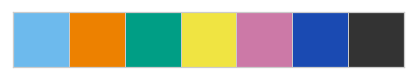

In [174]:
sns.palplot(sns.color_palette(['#6dbaed','#ed8100','#009e85','#f0e442','#cc79a7','#1a4ab2','#333333']))

In [217]:
# Import data as pandas dataframe 
intensifiers = pd.read_csv('intensifiers.csv', dtype={'User': object}, encoding='utf-8')
intensifiers['N_L1E_friends'] = (intensifiers['N_friends']*intensifiers['L1E_frnds']).astype(int)
intensifiers.drop(columns=['Unnamed: 0','Unnamed: 0.1','Url','Adverb','Date','L1E_frnds'], inplace=True)
len(intensifiers) # out: 42686

42686

In [218]:
print(intensifiers['Intensifier'].value_counts()[0:6])

very         18037
so           13080
too           4170
really        3899
quite         1023
extremely      348
Name: Intensifier, dtype: int64


In [219]:
# Create a new column with top 4 intensifiers and "OTHER"
def truncate_intensifier(row):
    if row['Intensifier'] in ['very','so','too','really']: 
        return row['Intensifier']
    else:
        return 'OTHER'

intensifiers['Top_intensifiers'] = intensifiers.apply(truncate_intensifier, axis=1)

In [220]:
# All locations
print(set(intensifiers['Location']))

{'Denmark', 'Vietnam', 'Switzerland', 'Laos', 'Scotland', 'Uzbekistan', 'Syria', 'Israel', 'Jamaica', 'Singapore', 'Jordan', 'Russia', 'Colombia', 'Kazakhstan', 'Austria', 'Ireland', 'Spain', 'Morocco', 'India', 'Portugal', 'Romania', 'Puerto Rico', 'France', 'U.S.A', 'Mongolia', 'Turkey', 'Norway', 'Brazil', 'Bangladesh', 'Germany', 'Thailand', 'Canada', 'Finland', 'Australia', 'Chile', 'Hungary', 'Mexico', 'Saudi Arabia', 'Belarus', 'Bulgaria', 'Italy', 'Argentina', 'United Kingdom', 'Sudan', 'Cyprus', 'Peru', 'Lebanon', 'Sweden', 'Hong Kong', 'China', 'Ecuador', 'Czech', 'Indonesia', 'Korea', 'Latvia', 'El Salvador', 'Panama', 'Poland', 'Venezuela', 'Other Countries', 'Ukraine', 'Egypt', 'Sri Lanka', 'Guatemala', 'Kyrgyzstan', 'Japan', 'Malaysia', 'Slovakia', 'Iran', 'United Arab Emirates', 'Myanmar', 'Tunisia', 'Belgium', 'New Zealand', 'The Philippines', 'Serbia', 'Taiwan'}


In [221]:
# Identify locations where English is majority and dominant language and create true/false column
english_dominant_locs = ['Australia', 'Scotland', 'Jamaica', 'New Zealand','United Kingdom', 
                         'Ireland', 'Canada', 'U.S.A']

def eng_maj_dom(row):
    if row['Location'] in english_dominant_locs:
        return True
    else:
        return False

intensifiers['Eng_dom_loc'] = intensifiers.apply(eng_maj_dom, axis=1)

In [222]:
# Get basic descriptive information about numerical columns
intensifiers.describe()

,Age,N_entries,Corr_made,Corr_rcvd,N_friends,Year,N_in_text,N_L1E_friends
count,42686.000000,42686.000000,42686.000000,42686.000000,42686.000000,42686.000000,42686.000000,42686.000000
mean,29.925503,47.878227,86.734152,66.546924,32.871597,2012.581596,8.019515,23.924589
std,6.532077,110.814071,487.879078,171.555211,90.236912,2.375450,12.509479,88.847757
min,18.000000,5.000000,0.000000,0.000000,1.000000,2008.000000,0.000000,0.000000
25%,26.000000,11.000000,6.000000,12.000000,12.000000,2011.000000,2.000000,4.000000
50%,29.000000,21.000000,17.000000,24.000000,23.000000,2012.000000,5.000000,9.000000
75%,32.000000,41.000000,45.000000,53.000000,25.000000,2014.000000,10.000000,18.000000
max,85.000000,4002.000000,17742.000000,5356.000000,1233.000000,2019.000000,400.000000,1219.000000


In [223]:
# see what the top collocations are
(intensifiers['Intensifier'] + ' ' + intensifiers['Adjective']).value_counts()[0:20]

so much             1749
very much           1643
so many             1519
too much            1269
very good           1008
very happy           946
very important       687
very hard            651
so happy             592
very difficult       590
very interesting     570
very tired           407
so good              395
so hard              390
very busy            358
very beautiful       353
very nice            351
too many             350
really good          348
so tired             323
dtype: int64

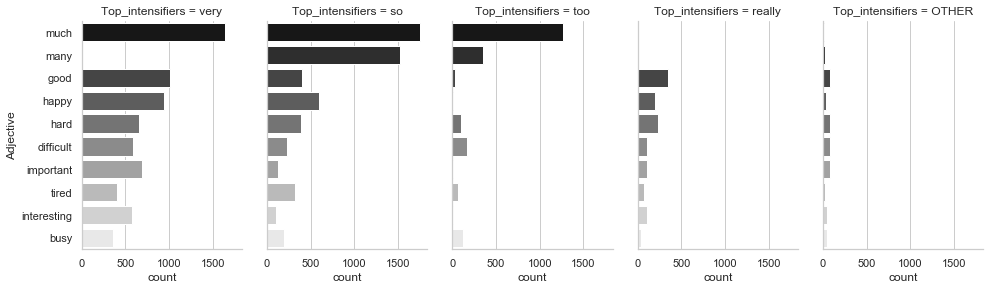

In [285]:
# PLOT: Top 20 adjectives for each intensifier
sns.catplot(y="Adjective", col='Top_intensifiers', col_wrap=5,
            data=intensifiers, col_order=['very','so','too','really','OTHER'], 
            palette='gray',
            kind="count", order = intensifiers['Adjective'].value_counts().index[0:10],
            height=4, aspect=0.7);

In [225]:
def scale_counts_user(row):
    return row[0]/total[row['User']]

user_counts = pd.crosstab([intensifiers.User, intensifiers.Age, intensifiers.N_L1E_friends, intensifiers.N_entries], 
                          intensifiers.Top_intensifiers)

total = dict(intensifiers['User'].value_counts())
user_counts = pd.DataFrame(user_counts.stack().reset_index())
user_counts['Prop_user'] = user_counts.apply(scale_counts_user, axis=1)
user_counts.head(n=5)

,User,Age,N_L1E_friends,N_entries,Top_intensifiers,0,Prop_user
0,10001,32,8,12,OTHER,0,0.000
1,10001,32,8,12,really,1,0.125
2,10001,32,8,12,so,1,0.125
3,10001,32,8,12,too,1,0.125
4,10001,32,8,12,very,5,0.625


{28: 2500, 27: 2495, 29: 2380, 26: 2245, 30: 1885, 25: 1825, 31: 1535, 32: 1465, 24: 1355, 33: 1055, 23: 945, 35: 800, 34: 790, 22: 725, 36: 610, 37: 585, 38: 400, 21: 370, 39: 320, 41: 275, 40: 265, 42: 230, 20: 220, 43: 210, 44: 180, 19: 155, 45: 120, 18: 105, 47: 100, 46: 100, 48: 85, 49: 70, 51: 45, 50: 45, 53: 45, 54: 40, 59: 30, 55: 25, 52: 25, 66: 20, 56: 20, 58: 15, 61: 15, 69: 10, 67: 10, 68: 10, 57: 10, 60: 10, 62: 5, 80: 5, 73: 5, 76: 5, 65: 5, 85: 5, 70: 5, 72: 5, 63: 5}


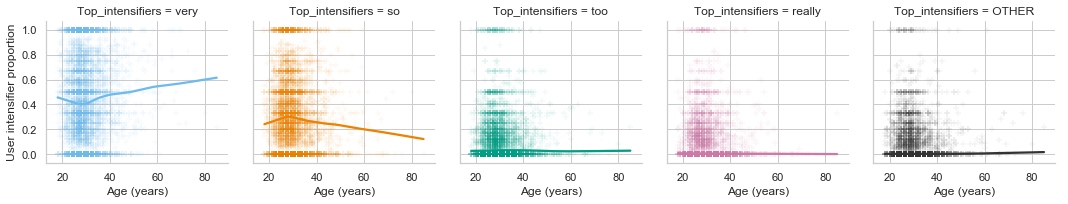

In [242]:
# PLOT: Age
print(dict(user_counts['Age'].value_counts()))
age = sns.lmplot(x='Age', y='Prop_user',col='Top_intensifiers', col_wrap=5, lowess=True, 
                 scatter=True, markers='+', scatter_kws={'alpha':0.05},
                 hue='Top_intensifiers', hue_order=['very','so','too','really','OTHER'],
                 col_order=['very','so','too','really','OTHER'], 
                 palette=['#6dbaed','#ed8100','#009e85','#cc79a7','#333333'],
                 data=user_counts, height=3)

age = age.set_axis_labels("Age (years)", "User intensifier proportion")


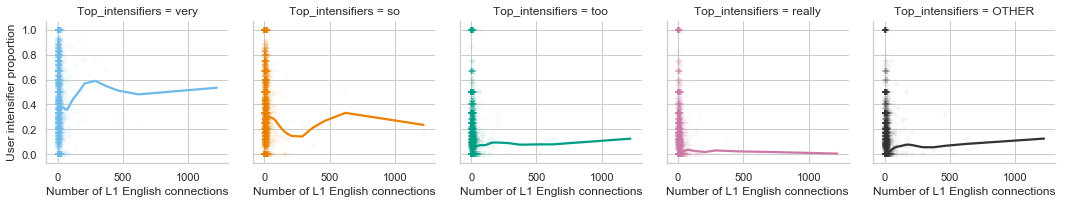

In [243]:
# PLOT: Number L1 English friends
l1f = sns.lmplot(x='N_L1E_friends', y='Prop_user', col='Top_intensifiers',col_wrap=5, lowess=True, 
                 scatter=True, markers='+', scatter_kws={'alpha':0.05},
                 hue='Top_intensifiers', hue_order=['very','so','too','really','OTHER'],
                 col_order=['very','so','too','really','OTHER'], 
                 palette=['#6dbaed','#ed8100','#009e85','#cc79a7','#333333'],
                 data=user_counts, height=3)

l1f = l1f.set_axis_labels("Number of L1 English connections", "User intensifier proportion")


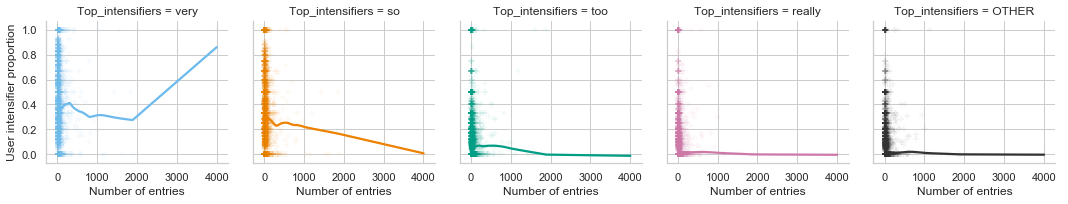

In [263]:
# PLOT: Number of entries
l1f = sns.lmplot(x='N_entries', y='Prop_user', col='Top_intensifiers',col_wrap=5,lowess=True, 
                 scatter=True, markers='+', scatter_kws={'alpha':0.05},
                 hue='Top_intensifiers', hue_order=['very','so','too','really','OTHER'],
                 col_order=['very','so','too','really', 'OTHER'], 
                 palette=['#6dbaed','#ed8100','#009e85','#cc79a7','#333333'],
                 data=user_counts,height=3)

l1f = l1f.set_axis_labels("Number of entries", "User intensifier proportion")


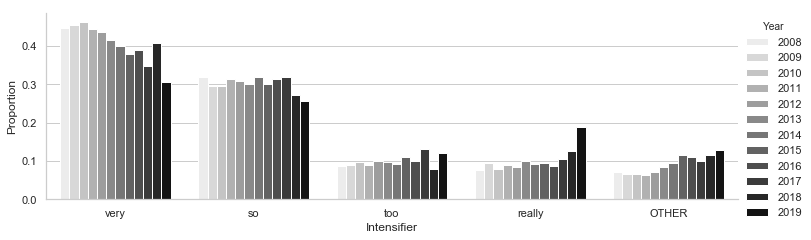

In [252]:
# PLOT: Year
#PREP
def scale_counts_year(row):
    return row[0]/total[row['Year']]

int_counts = pd.crosstab(intensifiers.Year, intensifiers.Top_intensifiers)
total = dict(intensifiers['Year'].value_counts())
int_counts = pd.DataFrame(int_counts.stack().reset_index())
int_counts['Prop_int'] = int_counts.apply(scale_counts_year, axis=1)

# PLOT
sns.catplot(x='Top_intensifiers', y='Prop_int', hue='Year', palette='gray_r',
            data=int_counts, kind='bar', order=['very','so','too','really','OTHER'],
            height=3.5, 
            aspect=3).set_axis_labels("Intensifier", "Proportion")

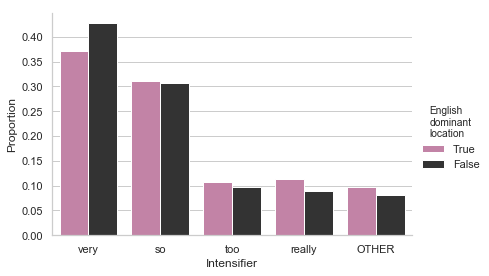

In [254]:
#PREP
def scale_counts_loc(row):
    return row[0]/total[row['Eng_dom_loc']]

loc_counts = pd.crosstab(intensifiers.Eng_dom_loc, intensifiers.Top_intensifiers)
total = dict(intensifiers['Eng_dom_loc'].value_counts())
loc_counts = pd.DataFrame(loc_counts.stack().reset_index())
loc_counts['Prop_eng_dom_loc'] = loc_counts.apply(scale_counts_loc, axis=1)

# PLOT: English dominant location
p_loc = sns.catplot(x="Top_intensifiers", y='Prop_eng_dom_loc', hue='Eng_dom_loc', 
                    hue_order=[True,False], palette=['#cc79a7','#333333'],
                    data=loc_counts, kind="bar", order = ['very','so','too','really','OTHER'],
                    height=4, aspect=1.5)
p_loc.set_axis_labels("Intensifier", "Proportion")
p_loc._legend.set_title('English\ndominant\nlocation')


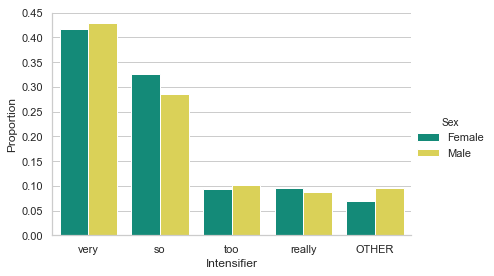

In [261]:
# PLOT: Sex
def scale_counts_sex(row):
    return row[0]/total[row['Sex']]

sex_counts = pd.crosstab(intensifiers.Sex, intensifiers.Top_intensifiers)
total = dict(intensifiers['Sex'].value_counts())
sex_counts = pd.DataFrame(sex_counts.stack().reset_index())
sex_counts['Prop_sex'] = sex_counts.apply(scale_counts_sex, axis=1)


p_sex = sns.catplot(x="Top_intensifiers", y='Prop_sex', hue='Sex', palette=['#009e85','#f0e442'],
            data=sex_counts, kind="bar", order = ['very','so','too','really','OTHER'],
            height=4, aspect=1.5)

p_sex.set_axis_labels("Intensifier", "Proportion")


# Logistic regression

In [256]:
import statsmodels.api as sm

In [257]:
keep = ['Top_intensifiers','Sex','Age','Eng_dom_loc','N_L1E_friends','N_entries','Corr_rcvd','Year']
dummy = intensifiers[keep]
dummy = pd.concat([dummy, pd.get_dummies(dummy['Eng_dom_loc'], prefix='EnLoc')], axis=1)
dummy = pd.concat([dummy, pd.get_dummies(dummy['Sex'])], axis=1)
dummy.drop(columns=['Sex','Eng_dom_loc','EnLoc_False','Male'], inplace=True)
dummy.sample(n=5)

,Top_intensifiers,Age,N_L1E_friends,N_entries,Corr_rcvd,Year,EnLoc_True,Female
39309,very,24,1219,285,557,2014,0,0
19522,very,30,47,29,62,2011,1,1
7574,very,21,4,31,18,2011,0,1
17749,really,43,8,37,46,2015,0,0
39583,too,27,29,42,33,2014,0,1


In [258]:
f = 'Top_intensifiers ~ Age + Female + EnLoc_True + N_L1E_friends + N_entries + Year'
mnl = sm.MNLogit.from_formula(formula=f, data=dummy).fit()

Optimization terminated successfully.
         Current function value: 1.368986
         Iterations 7


In [259]:
mnl.summary().tables[0]

Dep. Variable:,y,No. Observations:,42686
Model:,MNLogit,Df Residuals:,42658
Method:,MLE,Df Model:,24
Date:,"Mon, 15 Apr 2019",Pseudo R-squ.:,0.006059
Time:,13:25:17,Log-Likelihood:,-58437.
converged:,True,LL-Null:,-58793.
,,LLR p-value:,6.018e-135


In [260]:
mnl.summary().tables[1]

y=Top_intensifiers[really],coef,std err,z,P>|z|,[0.025,0.975]
Intercept,67.8980,20.546,3.305,0.001,27.628,108.168
Age,-0.0048,0.004,-1.235,0.217,-0.012,0.003
Female,0.3193,0.049,6.535,0.000,0.224,0.415
EnLoc_True,0.0160,0.079,0.203,0.839,-0.138,0.170
N_L1E_friends,-0.0019,0.000,-5.117,0.000,-0.003,-0.001
N_entries,-0.0002,0.000,-0.832,0.405,-0.001,0.000
Year,-0.0337,0.010,-3.302,0.001,-0.054,-0.014
y=Top_intensifiers[so],coef,std err,z,P>|z|,[0.025,0.975]
Intercept,117.1941,16.835,6.961,0.000,84.198,150.190
Age,-0.0005,0.003,-0.172,0.864,-0.007,0.006
